In [1]:
import starepandas
import geopandas
import pandas
import datetime
import matplotlib.pyplot as plt

# Loading Some Data

In [2]:
cities = ['Buenos Aires', 'Brasilia', 'Santiago', 
          'Bogota', 'Caracas', 'Sao Paulo', 'Bridgetown']

latitudes = [-34.58, -15.78, -33.45, 4.60, 10.48, -23.55, 13.1]
longitudes = [-58.66, -47.91, -70.66, -74.08, -66.86, -46.63, -59.62]
data =  {'City': cities, 
         'Latitude': latitudes, 'Longitude': longitudes}

cities = starepandas.STAREDataFrame(data)
stare = starepandas.stare_from_xy(cities.Longitude, cities.Latitude, level=26)
geom = geopandas.points_from_xy(cities.Longitude, cities.Latitude, crs='EPSG:4326')
cities.set_stare(stare, inplace=True)
cities.set_geometry(geom, inplace=True)
cities.set_trixels(inplace=True)

In [3]:
countries = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
samerica = countries[countries.continent=='South America']
samerica = starepandas.STAREDataFrame(samerica, add_stare=True, level=7,add_trixels=True)

brazil = samerica[samerica.name=='Brazil']

# Small Join

In [4]:
geopandas.sjoin(samerica, cities, how='left').head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,stare_left,trixels_left,index_right,City,Latitude,Longitude,stare_right,trixels_right
9,44293293,South America,Argentina,ARG,879400.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...","[1831874332805038087, 1831909517177126919, 183...",(POLYGON ((291.8925608203421 -55.3180135100298...,0.0,Buenos Aires,-34.58,-58.66,2.663379e+18,POLYGON ((301.3399990139821 -34.57999925034245...
10,17789267,South America,Chile,CHL,436100.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.63335...","[1822268999224786951, 1822339367968964615, 182...",(POLYGON ((289.5008879188417 -54.8762204926432...,2.0,Santiago,-33.45,-70.66,2.723775e+18,POLYGON ((289.3400003135371 -33.45000134637259...
20,2931,South America,Falkland Is.,FLK,281.8,"POLYGON ((-61.20000 -51.85000, -60.00000 -51.2...","[1807104534854500359, 1807245272342855687, 180...",(POLYGON ((299.325909392534 -51.68503082219077...,NaN,NaN,NaN,NaN,NaN,NaN
28,3360148,South America,Uruguay,URY,73250.0,"POLYGON ((-57.62513 -30.21629, -56.97603 -30.1...","[2632353982198054918, 2661627379775963142, 266...",(POLYGON ((304.8233831320491 -32.2478951580774...,NaN,NaN,NaN,NaN,NaN,NaN
29,207353391,South America,Brazil,BRA,3081000.0,"POLYGON ((-53.37366 -33.76838, -53.65054 -33.2...","[2749447572509687812, 2796735368597078020, 286...",(POLYGON ((306.3006615027466 -4.63080112809836...,1.0,Brasilia,-15.78,-47.91,2.867415e+18,POLYGON ((312.0899994632047 -15.78000129272085...


In [5]:
starepandas.stare_join(samerica, cities, how='left').head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,stare_left,trixels_left,key_right,City,Latitude,Longitude,stare_right,trixels_right
9,44293293,South America,Argentina,ARG,879400.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...","[1811572950109782022, 1811713687598137351, 181...",(POLYGON ((291.8925608203421 -55.3180135100298...,0.0,Buenos Aires,-34.58,-58.66,2.663379e+18,POLYGON ((301.3399990139821 -34.57999925034245...
10,17789267,South America,Chile,CHL,436100.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.63335...","[1810517418947117063, 1810622972063383559, 181...",(POLYGON ((289.5008879188417 -54.8762204926432...,2.0,Santiago,-33.45,-70.66,2.723775e+18,POLYGON ((289.3400003135371 -33.45000134637259...
20,2931,South America,Falkland Is.,FLK,281.8,"POLYGON ((-61.20000 -51.85000, -60.00000 -51.2...","[1807104534854500359, 1807245272342855687, 180...",(POLYGON ((299.325909392534 -51.68503082219077...,NaN,NaN,NaN,NaN,NaN,NaN
28,3360148,South America,Uruguay,URY,73250.0,"POLYGON ((-57.62513 -30.21629, -56.97603 -30.1...","[2632353982198054918, 2632494719686410247, 263...",(POLYGON ((304.8233831320491 -32.2478951580774...,NaN,NaN,NaN,NaN,NaN,NaN
29,207353391,South America,Brazil,BRA,3081000.0,"POLYGON ((-53.37366 -33.76838, -53.65054 -33.2...","[2643648165638569991, 2643753718754836487, 264...",(POLYGON ((306.3006615027466 -4.63080112809836...,1.0,Brasilia,-15.78,-47.91,2.867415e+18,POLYGON ((312.0899994632047 -15.78000129272085...


# Granule Intersect

In [6]:
fname = '../tests/data/granules/MYD05_L2.A2020060.1635.061.2020061153519.hdf'

In [7]:
modis = starepandas.read_granule(fname, add_stare=True, adapt_resolution=True, track_first=False)

trixels = modis.make_trixels()
modis.set_trixels(trixels, inplace=True)

geom = geopandas.points_from_xy(modis.lon, modis.lat, crs='EPSG:4326')
modis.set_geometry(geom, inplace=True)

## Geos based intersects test

In [8]:
start = datetime.datetime.now()
b = modis.intersects(brazil.iloc[0].geometry)
print(datetime.datetime.now() - start)

0:00:04.415014


## STARE based intersects test

In [9]:
start = datetime.datetime.now()
a = modis.stare_intersects(brazil['stare'].iloc[0])
print(datetime.datetime.now() - start)

0:00:00.178523


# Plot

<AxesSubplot:>

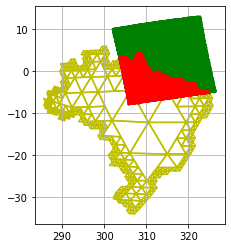

In [10]:
fig, ax = plt.subplots()
ax.grid(True)

brazil.plot(ax=ax, trixels=True, boundary=True, color='y', zorder=0)
#brazil.plot(ax=ax, trixels=False, facecolor="none", edgecolor='blue', zorder=1)
modis.plot(ax=ax, color='green', zorder=2)
modis[a].plot(ax=ax, color='red', trixels=True, zorder=3)

In [17]:
modis

,lat,lon,stare,Scan_Start_Time,Solar_Zenith,Solar_Azimuth,Sensor_Zenith,Sensor_Azimuth,Water_Vapor_Infrared,trixels,geometry
0,-4.923621,-33.579193,2833105768974759241,8.571477e+08,3199,-9648,6517,-9903,-9999,POLYGON ((326.2566998149539 -4.977374667151937...,POINT (-33.57919 -4.92362)
1,-4.956750,-33.786446,2833110603003551593,8.571477e+08,3178,-9645,6456,-9901,-9999,POLYGON ((326.1197896661117 -4.753368671091796...,POINT (-33.78645 -4.95675)
2,-4.988602,-33.986107,2833112722354712041,8.571477e+08,3158,-9642,6395,-9899,5392,POLYGON ((325.9091927187498 -5.177700478993788...,POINT (-33.98611 -4.98860)
3,-5.019270,-34.178722,2833084363820531337,8.571477e+08,3139,-9639,6335,-9897,5532,POLYGON ((325.9091927187498 -5.177700478993788...,POINT (-34.17872 -5.01927)
4,-5.048833,-34.364750,2833230005031123593,8.571477e+08,3120,-9636,6275,-9895,5304,"POLYGON ((325.666810443253 -5.165761696558127,...",POINT (-34.36475 -5.04883)
...,...,...,...,...,...,...,...,...,...,...,...
109615,10.103586,-57.200943,2499696282523506889,8.571480e+08,2017,-15104,6222,8010,-9999,"POLYGON ((302.5797126450333 10.08866040490541,...",POINT (-57.20094 10.10359)
109616,10.071841,-57.382591,2499763921241658537,8.571480e+08,2006,-15145,6281,8006,-9999,"POLYGON ((302.5797126450333 10.08866040490541,...",POINT (-57.38259 10.07184)
109617,10.038896,-57.570473,2499750202427574985,8.571480e+08,1994,-15189,6341,8003,2273,"POLYGON ((302.5797126450333 10.08866040490541,...",POINT (-57.57047 10.03890)
109618,10.004664,-57.765011,2499745802665205321,8.571480e+08,1982,-15235,6401,7999,2564,"POLYGON ((302.1039175542664 10.07126624681429,...",POINT (-57.76501 10.00466)


In [24]:
modis.iloc[0].stare

2833105768974759241

# Now doing Join

In [20]:
joined = starepandas.stare_join(modis, samerica, how='left')

In [19]:
joined

,lat,lon,stare_left,Scan_Start_Time,Solar_Zenith,Solar_Azimuth,Sensor_Zenith,Sensor_Azimuth,Water_Vapor_Infrared,trixels_left,geometry,key_right,pop_est,continent,name,iso_a3,gdp_md_est,stare_right,trixels_right
0,-4.923621,-33.579193,2833105768974759241,8.571477e+08,3199,-9648,6517,-9903,-9999,POLYGON ((326.2566998149539 -4.977374667151937...,POINT (-33.57919 -4.92362),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-4.956750,-33.786446,2833110603003551593,8.571477e+08,3178,-9645,6456,-9901,-9999,POLYGON ((326.1197896661117 -4.753368671091796...,POINT (-33.78645 -4.95675),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-4.988602,-33.986107,2833112722354712041,8.571477e+08,3158,-9642,6395,-9899,5392,POLYGON ((325.9091927187498 -5.177700478993788...,POINT (-33.98611 -4.98860),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-5.019270,-34.178722,2833084363820531337,8.571477e+08,3139,-9639,6335,-9897,5532,POLYGON ((325.9091927187498 -5.177700478993788...,POINT (-34.17872 -5.01927),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-5.048833,-34.364750,2833230005031123593,8.571477e+08,3120,-9636,6275,-9895,5304,"POLYGON ((325.666810443253 -5.165761696558127,...",POINT (-34.36475 -5.04883),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109615,10.103586,-57.200943,2499696282523506889,8.571480e+08,2017,-15104,6222,8010,-9999,"POLYGON ((302.5797126450333 10.08866040490541,...",POINT (-57.20094 10.10359),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109616,10.071841,-57.382591,2499763921241658537,8.571480e+08,2006,-15145,6281,8006,-9999,"POLYGON ((302.5797126450333 10.08866040490541,...",POINT (-57.38259 10.07184),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109617,10.038896,-57.570473,2499750202427574985,8.571480e+08,1994,-15189,6341,8003,2273,"POLYGON ((302.5797126450333 10.08866040490541,...",POINT (-57.57047 10.03890),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109618,10.004664,-57.765011,2499745802665205321,8.571480e+08,1982,-15235,6401,7999,2564,"POLYGON ((302.1039175542664 10.07126624681429,...",POINT (-57.76501 10.00466),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
joined = geopandas.GeoDataFrame(joined).set_geometry('trixels_left')

<AxesSubplot:>

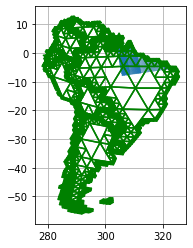

In [13]:
fig, ax = plt.subplots()
ax.grid(True)

#ax.set_ylim(-10, 10)
#ax.set_xlim(-60, -30)
samerica.plot(ax=ax, color='green')
joined.plot(ax=ax, column='name')

In [14]:
joined.head()

,lat,lon,stare_left,Scan_Start_Time,Solar_Zenith,Solar_Azimuth,Sensor_Zenith,Sensor_Azimuth,Water_Vapor_Infrared,trixels_left,geometry,key_right,pop_est,continent,name,iso_a3,gdp_md_est,stare_right,trixels_right
0,-4.923621,-33.579193,2833105768974759241,8.571477e+08,3199,-9648,6517,-9903,-9999,"POLYGON ((326.257 -4.977, 326.499 -4.989, 326....",POINT (-33.57919 -4.92362),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-4.956750,-33.786446,2833110603003551593,8.571477e+08,3178,-9645,6456,-9901,-9999,"POLYGON ((326.120 -4.753, 326.015 -4.966, 326....",POINT (-33.78645 -4.95675),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-4.988602,-33.986107,2833112722354712041,8.571477e+08,3158,-9642,6395,-9899,5392,"POLYGON ((325.909 -5.178, 326.151 -5.190, 326....",POINT (-33.98611 -4.98860),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-5.019270,-34.178722,2833084363820531337,8.571477e+08,3139,-9639,6335,-9897,5532,"POLYGON ((325.909 -5.178, 326.015 -4.966, 325....",POINT (-34.17872 -5.01927),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-5.048833,-34.364750,2833230005031123593,8.571477e+08,3120,-9636,6275,-9895,5304,"POLYGON ((325.667 -5.166, 325.772 -4.954, 325....",POINT (-34.36475 -5.04883),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Joining Granules